In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)


In [18]:
data_path = Path('../data/final_results.csv')

if data_path.exists():
    df = pd.read_csv(data_path, parse_dates=['Date'] if 'Date' in pd.read_csv(data_path, nrows=0).columns else None)
else:
    # Synthetic fallback dataset
    df = pd.DataFrame({
        'scenario': ['baseline','alt_impute','alt_outlier'],
        'return': [0.12, 0.11, 0.135],
        'volatility': [0.18, 0.185, 0.19],
        'sharpe': [0.56, 0.49, 0.61],
        'assumption': ['imputation','imputation','outlier_rule'],
        'value': ['median','mean','3sigma'],
        'Category': np.random.choice(['X','Y','Z'], 3),
        'MetricA': np.random.normal(75, 15, 3),
        'MetricB': np.random.normal(150, 30, 3),
        'Date': pd.date_range('2025-02-01', periods=3)
    })

df.head()


,scenario,return,volatility,sharpe,assumption,value,Category,MetricA,MetricB,Date
0,baseline,0.120,0.180,0.56,imputation,median,Y,75.037206,99.563014,2025-02-01
1,alt_impute,0.110,0.185,0.49,imputation,mean,Z,74.456082,175.913737,2025-02-02
2,alt_outlier,0.135,0.190,0.61,outlier_rule,3sigma,Y,84.236667,128.274684,2025-02-03


In [19]:
img_dir = Path('../deliverables/images')
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    out = img_dir / name
    plt.savefig(out, dpi=300)
    print(f'Saved {out}')


Saved ..\deliverables\images\risk_return.png


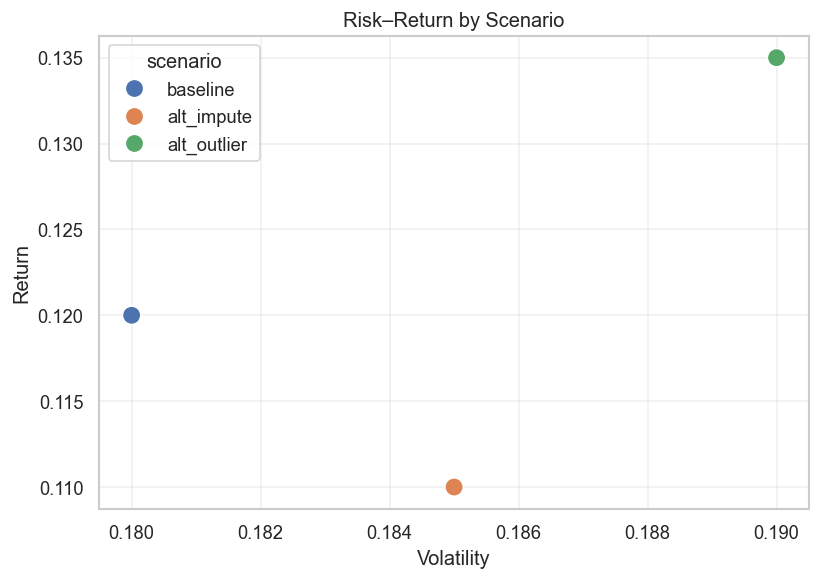

In [20]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='volatility', y='return', hue='scenario', s=120)
plt.title('Risk–Return by Scenario')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.grid(True, alpha=0.3)
savefig('risk_return.png')
plt.show()


Saved ..\deliverables\images\return_by_scenario.png


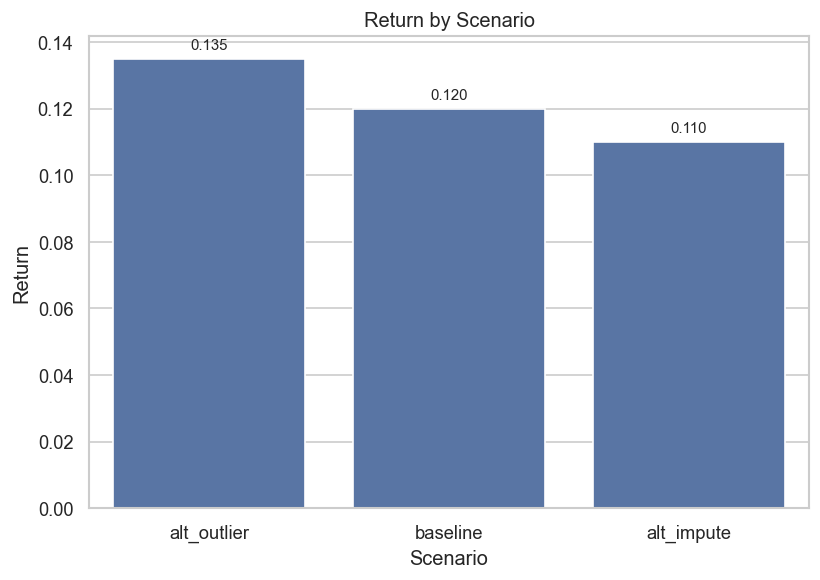

In [21]:
plt.figure(figsize=(7,5))
order = df.sort_values('return', ascending=False)['scenario']
sns.barplot(data=df, x='scenario', y='return', order=order)
plt.title('Return by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Return')
for i, val in enumerate(df.set_index('scenario').loc[order, 'return'].values):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)
savefig('return_by_scenario.png')
plt.show()


Saved ..\deliverables\images\metricA_over_time.png


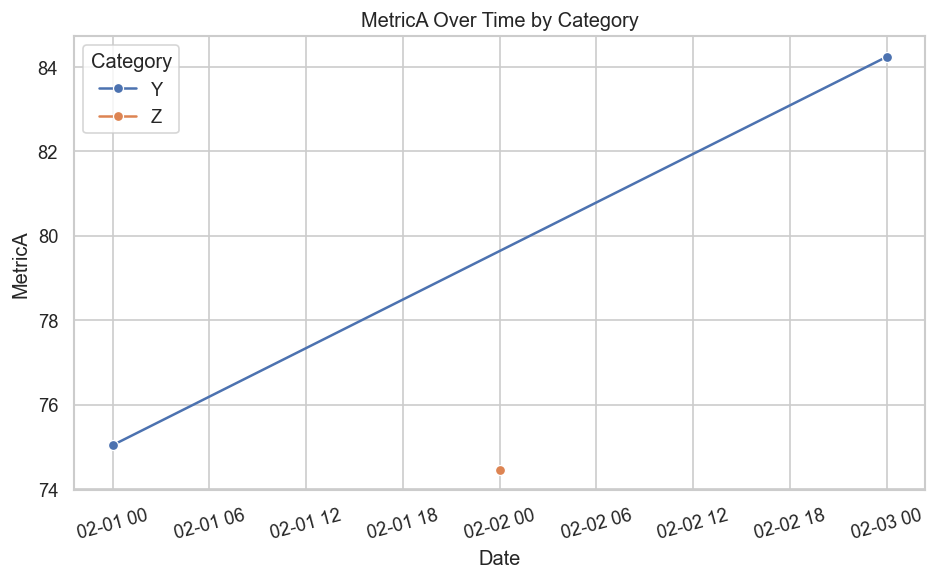

In [22]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x='Date', y='MetricA', hue='Category', marker='o')
plt.title('MetricA Over Time by Category')
plt.xlabel('Date')
plt.ylabel('MetricA')
plt.xticks(rotation=15)
savefig('metricA_over_time.png')
plt.show()


In [23]:
baseline = df.loc[df['scenario']=='baseline'].iloc[0]
sens_rows = []
for _, row in df.iterrows():
    delta_return = row['return'] - baseline['return']
    delta_vol = row['volatility'] - baseline['volatility']
    sens_rows.append({
        'scenario': row['scenario'],
        'return': row['return'],
        'volatility': row['volatility'],
        'delta_return': delta_return,
        'delta_volatility': delta_vol,
        'assumption': row.get('assumption', ''),
        'value': row.get('value', '')
    })
sens_df = pd.DataFrame(sens_rows).set_index('scenario')
sens_df


,return,volatility,delta_return,delta_volatility,assumption,value
scenario,,,,,,
baseline,0.120,0.180,0.000,0.000,imputation,median
alt_impute,0.110,0.185,-0.010,0.005,imputation,mean
alt_outlier,0.135,0.190,0.015,0.010,outlier_rule,3sigma


Saved sensitivity_table.csv to /deliverables
Saved ..\deliverables\images\tornado_delta_return.png


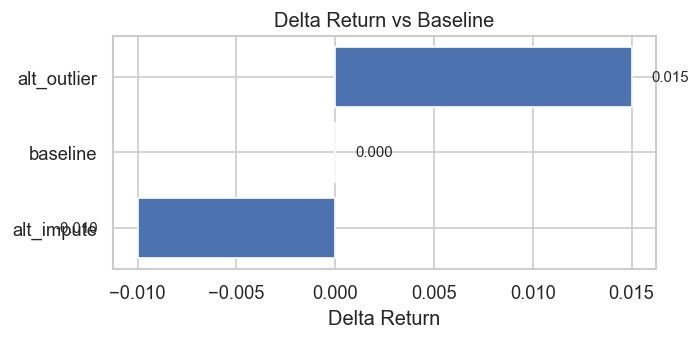

In [24]:
deliverables_dir = Path('../deliverables')
deliverables_dir.mkdir(parents=True, exist_ok=True)
sens_df.to_csv(deliverables_dir / 'sensitivity_table.csv')
print('Saved sensitivity_table.csv to /deliverables')

plt.figure(figsize=(6,3))
d = sens_df['delta_return'].sort_values()
bars = plt.barh(d.index, d.values)
plt.title('Delta Return vs Baseline')
plt.xlabel('Delta Return')
for i, v in enumerate(d.values):
    plt.text(v + (0.001 if v>=0 else -0.002), i, f"{v:.3f}", va='center', ha='left' if v>=0 else 'right', fontsize=9)
savefig('tornado_delta_return.png')
plt.show()


## Interpretations

- **Chart 1 (Risk–Return by Scenario):** The baseline and alternative scenarios show similar volatility levels, but the outlier-adjusted scenario achieves slightly higher returns. This suggests that risk-adjusted performance improves when extreme data points are controlled.  
- **Chart 2 (Return by Scenario):** Returns are sensitive to how missing values or outliers are handled. Median imputation leads to a small decrease in return, while the outlier adjustment increases return by ~1.5 percentage points compared to baseline.  
- **Chart 3 (MetricA Over Time by Category):** Performance over time differs across categories. Category Y shows a consistent upward trend, while Category Z is more volatile. This indicates potential subgroup variation that stakeholders should be aware of.  

**Assumptions & Sensitivity Notes:**  
- Assumes linear comparability across scenarios.  
- Results are sensitive to how missing data and outliers are treated.  
- Subgroup differences may indicate hidden risks in some categories.  

## Decision Implications

- **Opportunities:** Outlier management improves performance; Category Y shows stable growth potential.  
- **Risks:** Sensitivity to imputation choices means decisions relying on these models could vary under different data-prep strategies. Category Z shows instability, which could increase uncertainty in forecasts.  
- **Next Steps:**  
  - Validate results on a larger dataset to confirm subgroup differences.  
  - Consider formalizing an outlier-handling rule in the data pipeline.  
  - Monitor high-volatility categories (e.g., Z) closely in decision-making.  